# Importing Libraries

In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [2]:
import os
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

## Variables that can be changed

In [3]:
IMG_SIZE = 224 # image size for the model
EPOCHS = 50
BATCH_SIZE = 8
RESIZE_BACKGROUND = 500 # a random 224x224 crop will be used when training
CLASSES = ["Background", "Apple", "Banana"] # object classes
NUM_OBJ = len(CLASSES) # number of objects presented in training

# Visualising Data

**Defining paths to data and creating a list**

In [4]:
data_dir = './datasets/fruits'
apple_dir = os.path.join(data_dir, 'apple')
banana_dir = os.path.join(data_dir, 'banana')
background_dir = os.path.join(data_dir, 'background')

apple_list = os.listdir(apple_dir)
banana_list = os.listdir(banana_dir)
background_list = os.listdir(background_dir)

**Randomly selecting objects and background**

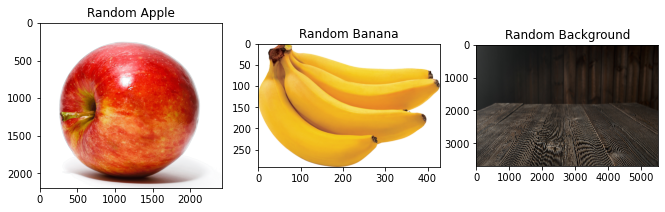

In [5]:
selected_apple = np.random.choice(apple_list)
selected_banana = np.random.choice(banana_list)
selected_background = np.random.choice(background_list)

plt.figure(figsize=(15, 5))

img = tf.io.read_file(os.path.join(apple_dir,selected_apple))
img = tf.image.decode_jpeg(img, channels=4)
img = tf.cast(img, tf.float32) / 255.0
plt.subplot(1, NUM_OBJ+1, 1)
plt.title('Random Apple')
plt.imshow(img)

img = tf.io.read_file(os.path.join(banana_dir,selected_banana))
img = tf.image.decode_jpeg(img, channels=4)
img = tf.cast(img, tf.float32) / 255.0
plt.subplot(1, NUM_OBJ+1, 2)
plt.title('Random Banana')
plt.imshow(img)

img = tf.io.read_file(os.path.join(background_dir,selected_background))
img = tf.image.decode_jpeg(img, channels=3)
img = tf.cast(img, tf.float32) / 255.0
plt.subplot(1, NUM_OBJ+1, 3)
plt.title('Random Background')
plt.imshow(img)

plt.show()

**Randomly creating an image of object with background**

Background image shape:  (3688, 5532, 3)
object size:  (3619, 3619, 4)


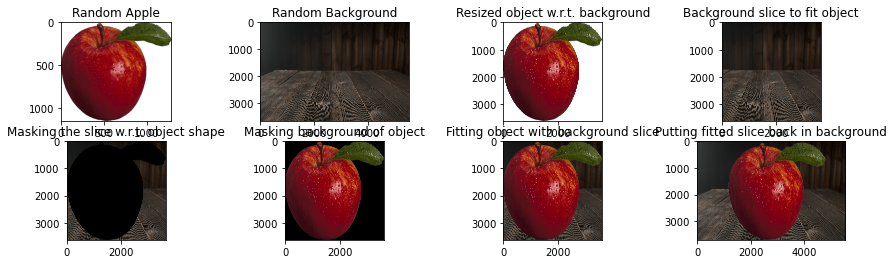

In [6]:
plt.figure(figsize=(15, 4))

choices = [None,
           os.path.join(apple_dir,np.random.choice(apple_list)),
           os.path.join(banana_dir,np.random.choice(banana_list)),]
choice = np.random.choice(len(CLASSES))

if choice:
    obj = tf.io.read_file(os.path.join(choices[choice]))
    obj = tf.image.decode_jpeg(obj, channels=4)
    obj = tf.cast(obj, tf.float32) / 255.0
    plt.subplot(2, 4, 1)
    plt.title('Random Apple')
    plt.imshow(obj)
    
    bg = tf.io.read_file(os.path.join(background_dir,np.random.choice(background_list)))
    bg = tf.image.decode_jpeg(bg, channels=3)
    bg = tf.cast(bg, tf.float32) / 255.0
    plt.subplot(2, 4, 2)
    plt.title('Random Background')
    plt.imshow(bg)
    print('Background image shape: ', bg.shape)
    
    max_size = min(bg.shape[0], bg.shape[1])
    min_size = int(max_size/5)
    obj_size = tf.random.uniform((), min_size , max_size, dtype=tf.int32)    
    
    resized_obj = tf.image.resize(obj, (obj_size, obj_size))
    print('object size: ', resized_obj.shape)
    plt.subplot(2, 4, 3)
    plt.title('Resized object w.r.t. background')
    plt.imshow(resized_obj)
    
    row0 = tf.random.uniform((), 0 , bg.shape[0] - obj_size, dtype=tf.int32)
    col0 = tf.random.uniform((), 0 , bg.shape[1] - obj_size, dtype=tf.int32)
    row1 = row0 + obj_size
    col1 = col0 + obj_size
    
    bg_slice1 = bg[row0:row1,col0:col1,:] # where we want to place `obj`
    plt.subplot(2, 4, 4)
    plt.title('Background slice to fit object')
    plt.imshow(bg_slice1)

    mask = (resized_obj[:,:,3] == 0) # find where the object is 0
    inverted_mask = np.invert(mask)
    mask = tf.cast(mask, tf.float32)
    inverted_mask = tf.cast(inverted_mask, tf.float32)

    bg_slice2 = np.expand_dims(mask, -1) * bg_slice1 # (h,w,1) x (h,w,3)
    plt.subplot(2, 4, 5)
    plt.title('Masking the slice w.r.t. object shape')
    plt.imshow(bg_slice2)

    obj_slice = np.expand_dims(np.logical_not(mask), -1)*resized_obj[:,:,:3] # "add" the object to the slice
    plt.subplot(2, 4, 6)
    plt.title('Masking background of object')
    plt.imshow(obj_slice)

    bg_slice = bg_slice2 + obj_slice
    plt.subplot(2, 4, 7)
    plt.title('Fitting object with background slice')
    plt.imshow(bg_slice)

    bg = bg.numpy()
    bg[row0:row1,col0:col1,:] = bg_slice
    plt.subplot(2, 4, 8)
    plt.title('Putting fitted slice back in background')
    plt.imshow(bg)
    
    #creating labeled image
    bg_label = np.zeros((bg.shape[0], bg.shape[1], 3))
    mask_bg = np.ones((bg.shape[0], bg.shape[1]))
    bg_label[row0:row1, col0:col1, choice] = inverted_mask
    mask_bg[row0:row1, col0:col1] = mask
    bg_label[:, :, 0] = mask_bg
    
else:
    bg = tf.io.read_file(os.path.join(background_dir,np.random.choice(background_list)))
    bg = tf.image.decode_jpeg(bg, channels=3)
    bg = tf.cast(bg, tf.float32) / 255.0
    bg = bg.numpy()
    plt.imshow(bg)
    
    bg_label = np.zeros((bg.shape[0], bg.shape[1], 3), dtype=np.float32)
    mask_bg = np.ones((bg.shape[0], bg.shape[1]))
    bg_label[:, :, 0] = mask_bg

del bg

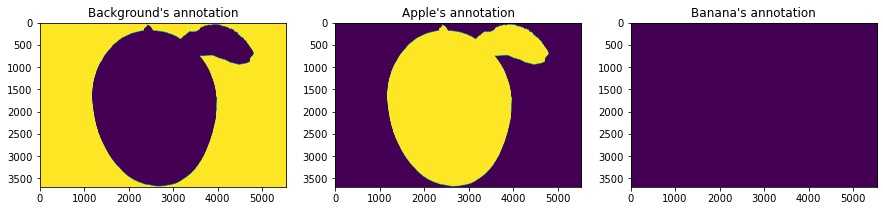

In [7]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Background\'s annotation')
plt.imshow(bg_label[:, :, 0], vmin=0, vmax=1)

plt.subplot(1, 3, 2)
plt.title('Apple\'s annotation')
plt.imshow(bg_label[:, :, 1])

plt.subplot(1, 3, 3)
plt.title('Banana\'s annotation')
plt.imshow(bg_label[:, :, 2])

In [8]:
# generate a list that contains one color for each class
colors = sns.color_palette(None, len(CLASSES))

for class_name, color in zip(CLASSES, colors):
    print(f'{class_name} -- {color}')

Background -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
Apple -- (1.0, 0.4980392156862745, 0.054901960784313725)
Banana -- (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)


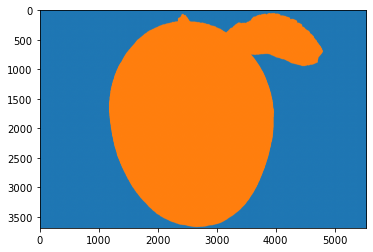

In [9]:
def give_color_to_annotation(annotation):
    
    seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')
    for c in range(len(CLASSES)):
        segc = annotation[:,:,c]
        seg_img[:,:,0] += segc*( colors[c][0])
        seg_img[:,:,1] += segc*( colors[c][1])
        seg_img[:,:,2] += segc*( colors[c][2])

    return seg_img

plt.imshow(give_color_to_annotation(bg_label))
del bg_label

**Loading image in the list to speed up image generation for training**

<span style="color:red">**NOTE** :</span>
If the number of image is more than tens or hundred, don't make list because it will be stored in RAM which can cause error while executing

In [10]:
def load_image(path, channels = 3):
    bg = tf.io.read_file(path)
    bg = tf.image.decode_jpeg(bg, channels=channels)
    return tf.cast(bg, tf.float32) / 255.0

# Loading background JPG image in there respective list with 3 channel
backgrounds = [load_image(os.path.join(background_dir, i)) for i in background_list]

# Loading objects in there respective list with 4 channel because those are PNG images
apples = [load_image(os.path.join(apple_dir, i), 4) for i in apple_list]
bananas = [load_image(os.path.join(banana_dir, i), 4) for i in banana_list]

**Creating a fuunction to resize the background image and taking a random crop of size 224x224**

In [11]:
# @tf.function
def resize_crop_img(img):
    img = tf.image.resize(img, (RESIZE_BACKGROUND, RESIZE_BACKGROUND), preserve_aspect_ratio=True)
    return tf.image.random_crop(img, (IMG_SIZE, IMG_SIZE, 3))

len_apples = len(apples)
len_bananas = len(bananas)
len_backgrounds = len(backgrounds)

# Data Generation
The data is generated with background and object with output defined as coordinates_of_objects at [0:4], target_objects_presence[4:-1] and object_appeared[-1].

In [12]:
def data_generator(batch_size=BATCH_SIZE):
    # generate image and targets
    while True:
        # Each epoch will have 50 batches
        for _ in range(50):
            X = np.zeros((batch_size, IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
            Y = np.zeros((batch_size, IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
            with tf.device('/gpu:0'):
                for i in range(batch_size):

                    random_bg = tf.random.uniform((), 0 , len_backgrounds, dtype=tf.int32)
                    bg = backgrounds[random_bg]
                    bg = resize_crop_img(bg)
                    bg = bg.numpy()
                    
                    bg_label = np.zeros((IMG_SIZE, IMG_SIZE, 3))
                    mask_bg = np.ones((IMG_SIZE, IMG_SIZE))

                    # == IF NUMBER OF OBJECTS IS CHANGED, THE CODE HERE NEEDED TO BE CHANGED
                    c_index = np.random.choice(list(range(3)))
                    if c_index:
                        if c_index == 1:
                            index = tf.random.uniform((), 0 , len_apples, dtype=tf.int32)
                            obj = apples[index]
                        else:
                            index = tf.random.uniform((), 0 , len_bananas, dtype=tf.int32)
                            obj = bananas[index]
                    # == CODE NEEDED TO BE CHANGED TILL HERE

                        max_size = IMG_SIZE
                        min_size = int(max_size/5)
                        obj_size = tf.random.uniform((), min_size , max_size, dtype=tf.int32)
                        resized_obj = tf.image.resize(obj, (obj_size, obj_size))

                        row0 = tf.random.uniform((), 0 , IMG_SIZE - obj_size, dtype=tf.int32)
                        col0 = tf.random.uniform((), 0 , IMG_SIZE - obj_size, dtype=tf.int32)
                        row1 = row0 + obj_size
                        col1 = col0 + obj_size

                        bg_slice = bg[row0:row1,col0:col1,:]
                        mask = (resized_obj[:,:,3] == 0)
                        inverted_mask = np.invert(mask)
                        mask = tf.cast(mask, tf.float32)
                        inverted_mask = tf.cast(inverted_mask, tf.float32)

                        bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1) x (h,w,3)
                        obj_slice = np.expand_dims(np.logical_not(mask), -1)*resized_obj[:,:,:3]
                        bg_slice = bg_slice + obj_slice
                        bg[row0:row1,col0:col1,:] = bg_slice

                        mask_bg[row0:row1, col0:col1] = mask
                        bg_label[:, :, 0] = mask_bg

                        bg_label[row0:row1, col0:col1, c_index] = inverted_mask

                        mask_bg[row0:row1, col0:col1] = mask
                    bg_label[:, :, 0] = mask_bg

                    X[i] = bg
                    Y[i] = bg_label
                with tf.device('/gpu:0'):
                    yield X, Y

Just checking if function **data_generator()** is running properly

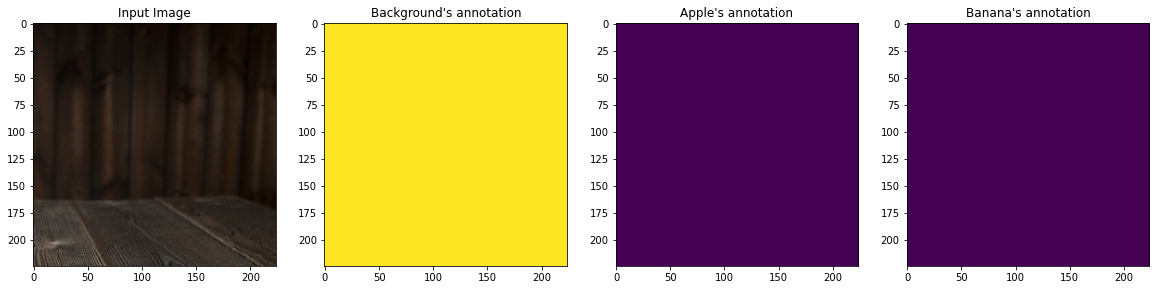

In [13]:
xx = None
yy = None
for x, y in data_generator():
    xx, yy = x, y

    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.title('Input Image')
    plt.imshow(xx[2])
    plt.subplot(1, 4, 2)
    plt.title('Background\'s annotation')
    plt.imshow(yy[2, :, :, 0], vmin=0, vmax=1)
    plt.subplot(1, 4, 3)
    plt.title('Apple\'s annotation')
    plt.imshow(yy[2, :, :, 1])
    plt.subplot(1, 4, 4)
    plt.title('Banana\'s annotation')
    plt.imshow(yy[2, :, :, 2])
    break

## Defining custom loss function

In [14]:
from tensorflow.keras.losses import Loss
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy

class CustomCrossEntropy(Loss):
    
    def __init__(self, priority = 1):
        super().__init__()
        self.priority = priority
        
    def call(self, y_true, y_pred):
        cce_priority = categorical_crossentropy(y_true[:,:,1:], y_pred[:,:,:,1:])
        cce_rest = categorical_crossentropy(y_true, y_pred)
        return self.priority*cce_priority + cce_rest